In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import load_model
import os
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/RGB_5G.zip" -d "/content/dataset/"  

Archive:  /content/drive/MyDrive/RGB_5G.zip
   creating: /content/dataset/RGB_5G/Test/
   creating: /content/dataset/RGB_5G/Test/16QAM/
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB1.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB10.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB100.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB101.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB102.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB103.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB104.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB105.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB106.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB107.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB108.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB109.png  
  inflating: /content/dataset/RGB_5G/Test/16QAM/4QAM_RGB11.png  
  inflatin

In [ ]:
IMAGE_SIZE = [224, 224]
valid_path = r'/content/dataset/RGB_5G/Test'
train_path = r'/content/dataset/RGB_5G/Train'

In [ ]:
mobilenet = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


## Baseline

For the baseline model, we will be implementing a SGD model from sklearn trained with 1000 max iterations and the default settings. As we have seen that the dataset presents category imbalancing, we will use the Random Undersampling over the majority classes. We also use the StandarScaler before the SGD.

As we have many rows for each bird vocalization, when we predict, we need to ensure that all those measures just add up to one vocalization. For that, we will implement majority voting over the predictions grouped by the id of the bird vocalization. 

**Evaluation Methodologies**

We will be using the following metrics to evaluate and compare our models:
* F1 Score
<br>
<center>
<img src="https://inside-machinelearning.com/wp-content/uploads/2021/09/F1-Score.png" width="300px">
* Confusion Matrix
</center>
<br>
<center>
<img src="https://miro.medium.com/max/712/1*Z54JgbS4DUwWSknhDCvNTQ.png" width="300px">
</center>

Final evaluations are done over a 5-fold cross validation as we show in the next figure.
<br>
<center>  
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="500px">
</center>

In [ ]:
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
folders = glob(r'/content/dataset/RGB_5G/Train/*')

In [ ]:
x = Flatten()(mobilenet.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model_mobilenet_RGB = Model(inputs=mobilenet.input, outputs=prediction)

In [ ]:
model_mobilenet_RGB.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 1400 images belonging to 5 classes.
Found 600 images belonging to 5 classes.


In [ ]:
history_mobilenet_RGB = model_mobilenet_RGB.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)    

model_mobilenet_RGB.save('mobilenet_RGB_model.h5')
print("model saved to Disk.")

Epoch 1/10
44/44 [==============================] - 126s 3s/step - loss: 8.1415 - accuracy: 0.2507 - val_loss: 3.7374 - val_accuracy: 0.2550
Epoch 2/10
44/44 [==============================] - 121s 3s/step - loss: 2.8738 - accuracy: 0.4036 - val_loss: 3.5839 - val_accuracy: 0.3150
Epoch 3/10
44/44 [==============================] - 121s 3s/step - loss: 2.0402 - accuracy: 0.4929 - val_loss: 3.0929 - val_accuracy: 0.3367
Epoch 4/10
44/44 [==============================] - 119s 3s/step - loss: 1.9906 - accuracy: 0.5521 - val_loss: 3.9604 - val_accuracy: 0.2800
Epoch 5/10
44/44 [==============================] - 124s 3s/step - loss: 2.0766 - accuracy: 0.5579 - val_loss: 3.2956 - val_accuracy: 0.3300
Epoch 6/10
44/44 [==============================] - 121s 3s/step - loss: 1.8622 - accuracy: 0.5843 - val_loss: 4.7080 - val_accuracy: 0.3217
Epoch 7/10
44/44 [==============================] - 120s 3s/step - loss: 1.8434 - accuracy: 0.6386 - val_loss: 3.9557 - val_accuracy: 0.3250
Epoch 8/10
44

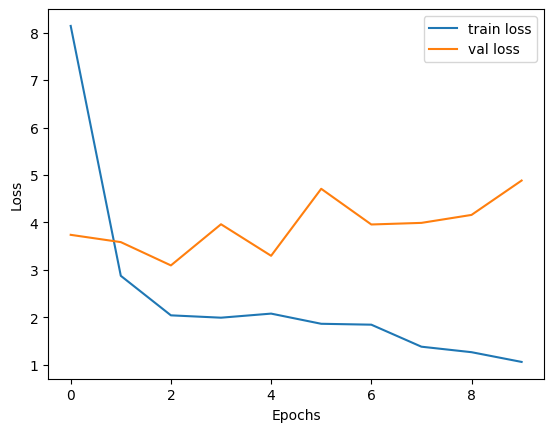

In [ ]:
plt.plot(history_mobilenet_RGB.history['loss'], label='train loss')
plt.plot(history_mobilenet_RGB.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

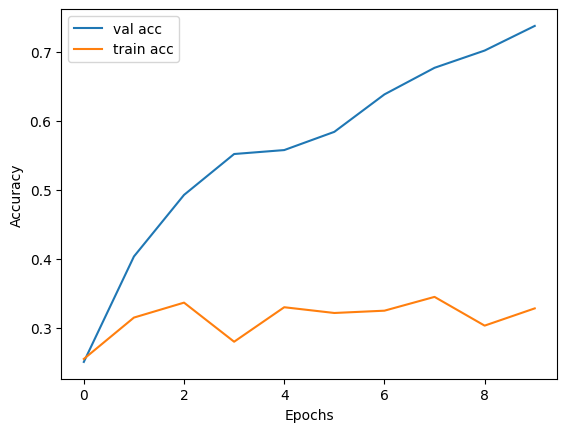

In [ ]:
plt.plot(history_mobilenet_RGB.history['accuracy'], label='val acc')
plt.plot(history_mobilenet_RGB.history['val_accuracy'], label='train acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
model_mobilenet_new_RGB = load_model('mobilenet_RGB_model.h5')

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_data_generator = test_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


Found 600 images belonging to 5 classes.


In [ ]:
# Majority voting over predictions
grouped_test_preds = group_df_by_index(test_preds)
grouped_test_preds.columns = ['category']

# Grouped test GroundTruth values
GT_grouped_test = group_df_by_index(TEST)
grouped_test_preds.head(5)

,category
8,Himantopus himantopus
9,Motacilla flava
10,Charadrius alexandrinus
11,Charadrius alexandrinus
12,Anas platyrhynchos


SGDClassifier - Test
[TEST] F1-score :  11.803204139850461 %


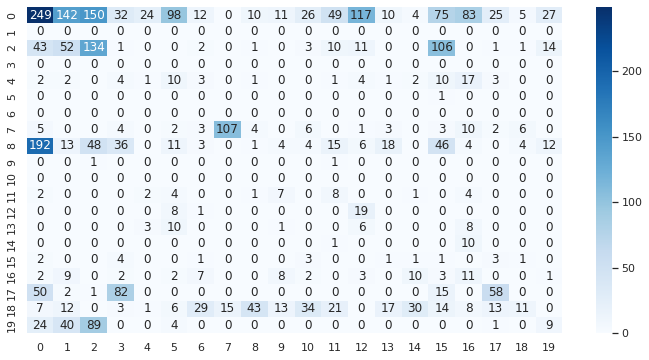

In [ ]:
print("SGDClassifier - Test")
cf_mat = confusion_matrix(grouped_test_preds['category'],GT_grouped_test['category'])
sns.heatmap(cf_mat,annot=True, fmt='d', cmap='Blues');
print("[TEST] F1-score : ", f1_score(grouped_test_preds['category'],GT_grouped_test['category'], average='macro') * 100, "%")

We see that we are obtaining a f1-score of 14-15 % and that the confusion matrix does not show any evidence of the model learning something qualitativley good. We will try the same baseline approach dropping some outliers and we will cross validate the results.

For dropping outliers, we will exclude all samples from the predictors that are 2.5 standard deviations away from the feature mean. This lets supposes to drop less than the 1% of the data in a normal distribution (it will be a good practice to check normality).

In [ ]:
TRAIN_NO_OUTLIERS = remove_outliers(TRAIN,predictors,2.5)

Dropping outliers on column: chroma_stft
Dropping outliers on column: rmse
Dropping outliers on column: spectral_centroid
Dropping outliers on column: spectral_bandwidth
Dropping outliers on column: rolloff
Dropping outliers on column: zcr
Dropping outliers on column: mfcc


---------------
Average F1-score over 5-fold cross-validation: 11.99 %
Last k-fold confusion matrix


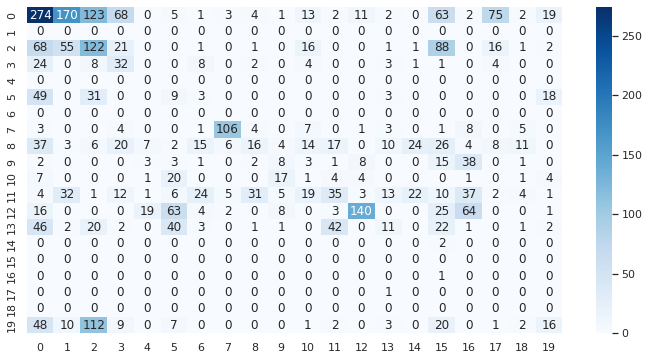

In [ ]:
X = TRAIN_NO_OUTLIERS[predictors]
y = TRAIN_NO_OUTLIERS['category']

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
accuracies = []
f1_scores = []

for train_index, test_index in kf.split(X):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Resample training data
    sampler = RandomUnderSampler(sampling_strategy='majority')
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

    # Fit model and make predictions
    clf = make_pipeline(StandardScaler(),
                        SGDClassifier(max_iter=2000, tol=1e-1,random_state=SEED))
    clf.fit(X_resampled, y_resampled)
    test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)

    # Majority voting over predictions
    grouped_test_preds = group_df_by_index(test_preds)
    grouped_test_preds.columns = ['category']

    # Grouped test GT values
    GT_grouped_test = group_df_by_index(TEST)
    GT_grouped_test = GT_grouped_test.reindex(grouped_test_preds.index)

    # Compute metrics
    cf_mat = confusion_matrix(grouped_test_preds['category'], GT_grouped_test['category'])
    f1 = f1_score(grouped_test_preds['category'], GT_grouped_test['category'], average='macro')
    accuracy = np.trace(cf_mat) / np.sum(cf_mat)

    accuracies.append(accuracy)
    f1_scores.append(f1)

avg_accuracy = np.mean(accuracies) * 100
avg_f1_score = np.mean(f1_scores) * 100
print(15*'-')
print("Average F1-score over 5-fold cross-validation: {:.2f} %".format(avg_f1_score))

print("Last k-fold confusion matrix")
sns.heatmap(cf_mat,annot=True, fmt='d', cmap='Blues');

As we observe, dropping outliers does not improve the qualitative results at all. Let's dive deeper into machine learning and try to improve those resutls with ensamble methods.

## Ensamble Methods 

In this section we will try to improve the results by implementing ensamble models. We will be using:

* LightGBM 
* AdaBoost
* RandomForest

In this case, we will train those models with the no outliers train dataset that we created in the last section. We will also implement 5-fold cross validation and random underampling. The evaluation methodologies will remain the same.

In [ ]:
def ensemble_model_kfold(X, y, predictors, TEST, group_df_by_index, n_splits=5):
    models = [LGBMClassifier(), AdaBoostClassifier(), RandomForestClassifier()]
    results = []
    
    sampler = RandomUnderSampler(sampling_strategy='majority')
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    kf = KFold(n_splits=n_splits)
    
    for (i, model) in enumerate(models):
        print("[PROGRESS] Fitting model {} of {}".format(i + 1, len(models)))
        accuracies = []
        f1_scores = []
        cf_mats = []
        for train_index, val_index in kf.split(X_resampled):
            X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
            y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]
            
            clf = make_pipeline(StandardScaler(), model)
            clf.fit(X_train, y_train)

            test_preds = pd.DataFrame(clf.predict(TEST[predictors]), index=TEST.index)
            grouped_test_preds = group_df_by_index(test_preds)
            grouped_test_preds.columns = ['category']

            GT_grouped_test = group_df_by_index(TEST)

            cf_mat = confusion_matrix(grouped_test_preds['category'], GT_grouped_test['category'])
            accuracy = np.trace(cf_mat) / np.sum(cf_mat)
            f1_sc = f1_score(grouped_test_preds['category'], GT_grouped_test['category'], average='macro')

            accuracies.append(accuracy)
            f1_scores.append(f1_sc)
            cf_mats.append(cf_mat)

        results.append({'model': model.__class__.__name__, 
                        'accuracy': np.mean(accuracies),
                        'f1_score': np.mean(f1_scores),
                        'confusion_matrix': np.mean(cf_mats, axis=0)})
        
    return results

In [ ]:

X = TRAIN_NO_OUTLIERS[predictors]
y = TRAIN_NO_OUTLIERS['category']

GT_grouped_test = group_df_by_index(TEST)

results = ensemble_model_kfold(X, y, predictors, TEST, group_df_by_index)

for result in results:
    print("[TEST] Model: ", result['model'])
    print("[TEST] Accuracy: {:.2f} %".format(result['accuracy']*100))
    print("[TEST] F1-score : {:.2f} %".format(result['f1_score']*100))
    print("\n")

[PROGRESS] Fitting model 1 of 3
[PROGRESS] Fitting model 2 of 3
[PROGRESS] Fitting model 3 of 3
[TEST] Model:  LGBMClassifier
[TEST] Accuracy: 39.46 %
[TEST] F1-score : 26.28 %


[TEST] Model:  AdaBoostClassifier
[TEST] Accuracy: 26.94 %
[TEST] F1-score : 12.73 %


[TEST] Model:  RandomForestClassifier
[TEST] Accuracy: 40.68 %
[TEST] F1-score : 27.56 %




LGBM Classifier


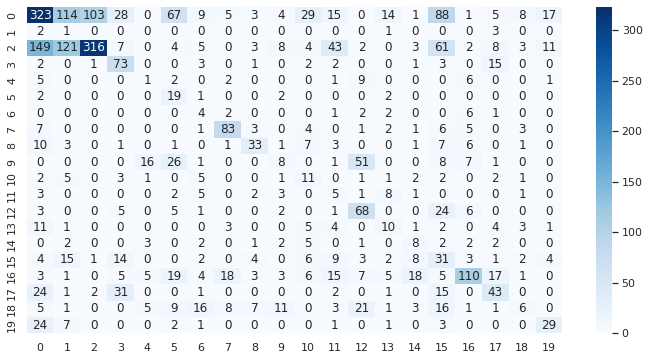

In [ ]:
print("LGBM Classifier")
sns.heatmap(results[0]['confusion_matrix'],annot=True, fmt='.0f', cmap='Blues');

Adaboost Classifier


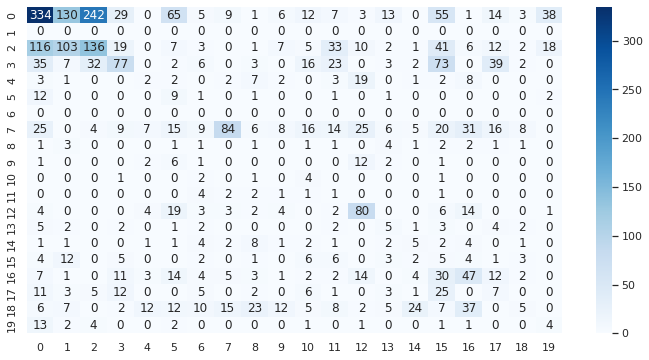

In [ ]:
print("Adaboost Classifier")
sns.heatmap(results[1]['confusion_matrix'],annot=True, fmt='.0f', cmap='Blues');

Random Forest Classifier


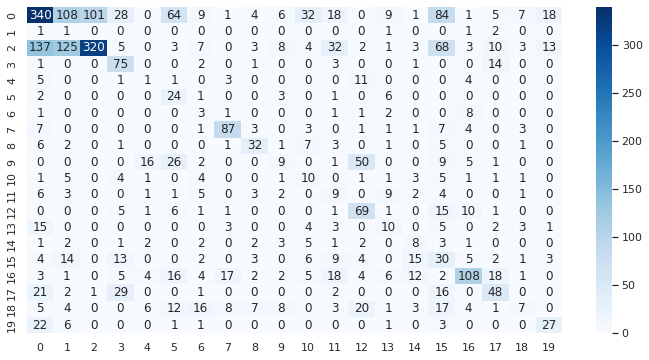

In [ ]:
print("Random Forest Classifier")
sns.heatmap(results[2]['confusion_matrix'],annot=True, fmt='.0f', cmap='Blues');

In [ ]:
predictions = model_mobilenet_new_RGB.predict(test_data_generator, steps=test_steps_per_epoch)


19/19 [==============================] - 30s 2s/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
print(predicted_classes)

[0 1 0 0 0 4 3 1 3 0 0 3 0 0 3 0 0 0 0 0 0 0 4 0 3 3 0 3 4 3 0 1 0 0 0 0 2
 0 0 0 0 1 3 0 0 0 0 0 0 0 3 4 1 0 3 2 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 3 4 0 4 4 0 0 3 0 0 0 3 3 0 2 2 0 0 0 0 1 0 0 0 0 0 3 1 0 0 3 3 0 0 3 0 0
 3 0 3 0 0 0 3 3 0 4 4 0 4 3 4 0 1 4 4 1 1 3 4 4 3 3 3 4 3 3 4 3 4 1 1 4 4
 4 4 1 4 4 3 1 3 1 4 3 4 4 1 4 3 3 3 4 3 3 0 4 3 3 4 0 4 3 4 3 0 3 3 4 0 3
 3 0 3 3 4 4 4 3 0 1 4 4 1 0 1 4 3 0 4 4 1 4 3 3 3 3 4 3 4 4 3 0 3 0 4 3 3
 4 2 3 3 0 4 4 3 0 4 4 3 1 4 4 3 3 0 0 0 0 1 3 0 0 3 0 0 3 0 0 3 4 2 0 0 0
 1 0 0 3 3 3 0 0 1 0 0 3 3 0 3 0 4 3 0 0 0 0 0 0 0 0 4 0 0 0 0 3 0 0 3 3 0
 1 0 0 3 3 0 4 0 3 3 4 0 1 0 0 4 0 0 3 0 0 2 3 0 3 3 4 0 4 4 0 0 0 0 3 0 3
 4 0 0 3 3 0 3 4 0 0 0 0 0 2 3 0 3 0 3 0 0 0 1 0 3 0 0 4 3 3 3 3 3 3 3 3 1
 4 0 4 4 3 3 1 4 4 1 3 1 4 3 4 4 4 4 3 3 4 4 3 3 3 4 4 4 4 3 3 1 3 4 3 4 4
 3 3 4 3 4 4 4 4 3 4 3 3 3 3 4 1 3 4 4 1 1 0 3 3 3 1 4 1 3 4 4 0 3 3 0 4 3
 3 3 3 3 4 1 4 3 0 3 4 4 3 3 3 2 3 3 3 3 3 3 3 4 3 3 3 3 1 3 3 4 3 3 4 0 4
 3 3 4 4 3 3 3 0 3 3 3 4 

In [ ]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
cmat = confusion_matrix(true_classes, predicted_classes)
acc = accuracy_score(true_classes, predicted_classes)
print(report) 
print(cmat)
print(acc)

              precision    recall  f1-score   support

       16QAM       0.44      0.64      0.52       120
       32QAM       0.25      0.12      0.16       120
        4QAM       0.33      0.03      0.05       120
       64QAM       0.29      0.51      0.37       120
        8QAM       0.29      0.35      0.31       120

    accuracy                           0.33       600
   macro avg       0.32      0.33      0.28       600
weighted avg       0.32      0.33      0.28       600

[[77  9  4 23  7]
 [15 14  1 43 47]
 [69  6  3 31 11]
 [ 6 12  1 61 40]
 [ 7 16  0 55 42]]
0.3283333333333333


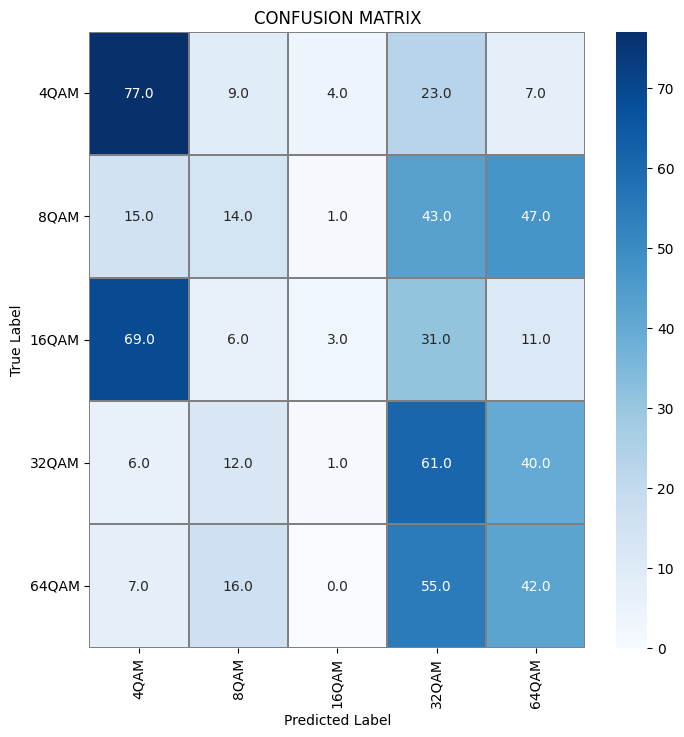

In [ ]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['4QAM', '8QAM', '16QAM', '32QAM', '64QAM'])
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_yticklabels(['4QAM', '8QAM', '16QAM', '32QAM', '64QAM'])

plt.title("CONFUSION MATRIX")
plt.show()